Compare the NN prediction results with the human expert

In [50]:
import os
import tifffile
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
os.chdir("/home/ws/er5241/Repos/training-repo/")

from inference import Segmenter

### load models for segmenting heartkidney
- i) non-merged
    - 4 mapped as 1
    - 6 mapped as 3

- ii) merged
    - 4,6 mapped as 1

In [53]:
# load non-merged  (2021-10-06_18-30-45)
model = {'network_type': 'Unet', 'encoder_name': 'resnet18', 'classes': 7, 'in_channels': 1}
checkpoint = {'checkpoint_addr': '/home/ws/er5241/logs/medaka-supervised/2021-10-06_18-30-45/logdir/checkpoints/best.pth',
              'checkpoint_key': 'model_state_dict'}
processing = {'batch_size': 1, 'dtype': 'uint8'}

seger_nonMerged = Segmenter(model_config=model, checkpoint_config=checkpoint, processing_parameters=processing)



# load merged  (2022-03-29_16-53-22)
model = {'network_type': 'Unet', 'encoder_name': 'resnet18', 'classes': 6, 'in_channels': 1}
checkpoint = {'checkpoint_addr': '/home/ws/er5241/logs/medaka-supervised/2022-03-29_16-53-22/logdir/checkpoints/best.pth',
              'checkpoint_key': 'model_state_dict'}
processing = {'batch_size': 1, 'dtype': 'uint8'}

seger_merged = Segmenter(model_config=model, checkpoint_config=checkpoint, processing_parameters=processing)

>>>>>>>>>>>>>>>> initializing model
trainable parameters in model: 14322807
<<<<<<<<<<<<<<<< done in 0.34 sec.
>>>>>>>>>>>>>>>> loading checkpoint
<<<<<<<<<<<<<<<< done in 0.066 sec.
>>>>>>>>>>>>>>>> initializing model
trainable parameters in model: 14322662
<<<<<<<<<<<<<<<< done in 0.28 sec.
>>>>>>>>>>>>>>>> loading checkpoint
<<<<<<<<<<<<<<<< done in 0.071 sec.


### select random sample

In [242]:
fls = glob('/mnt/HD-LSDF/Medaka/segmentations/workshop/medaka_decropped/*.tif')

img_addr = np.random.choice(fls)
#img_addr = '/mnt/HD-LSDF/Medaka/segmentations/workshop/medaka_decropped/508.tif'
fl_id = img_addr.split('/')[-1]
msk_addr = glob(f'/mnt/HD-LSDF/Medaka/segmentations/workshop/heartkidney_decropped/*-{fl_id}')[0]
print(img_addr)
print(msk_addr)

img = tifffile.imread(img_addr)
msk = tifffile.imread(msk_addr)

/mnt/HD-LSDF/Medaka/segmentations/workshop/medaka_decropped/513.tif
/mnt/HD-LSDF/Medaka/segmentations/workshop/heartkidney_decropped/04-513.tif


In [243]:
u_vals, c_vals = np.unique(msk, return_counts=True)
print(u_vals, c_vals)

u_vals, c_vals = u_vals[1:], c_vals[1:]  # skip background
for u,c in zip(u_vals, c_vals):
  print(f'{u} : {c*100/sum(c_vals):.2f}')

[ 0  4  5  6  7  9 10] [304541178      3085     52738     10930    114277     79780    107122]
4 : 0.84
5 : 14.33
6 : 2.97
7 : 31.06
9 : 21.68
10 : 29.11


### compare markup with predictions

In [244]:
pred_nonMerged = seger_nonMerged.process_one_volume(img)
pred_merged = seger_merged.process_one_volume(img)

147


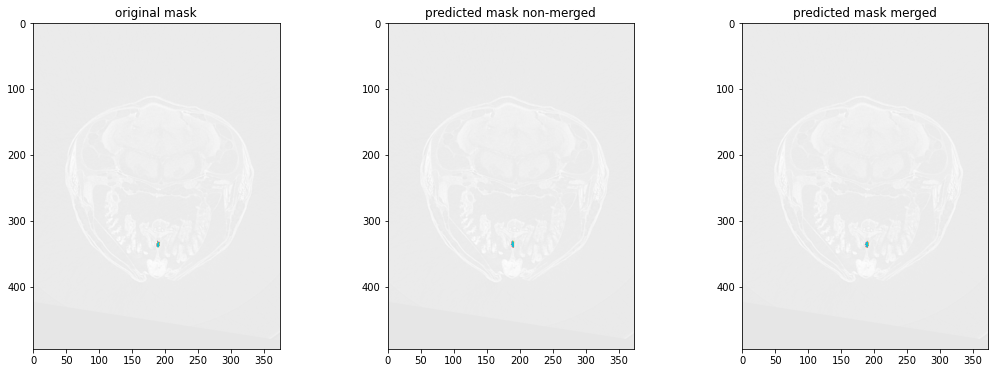

In [246]:
msk[(msk!=4) & (msk!=6)] = 0  # mask only containing 4 or 6

ne_slc = np.where(msk.sum((1, 2))>0)[0]
print(len(ne_slc))
slice_id = ne_slc[len(ne_slc)//2] # plot specific slice to compare the resutls

fig, axs = plt.subplots(1,3, figsize=(18,6))

plt.axes(axs[0])
plt.imshow(img[slice_id], cmap='gray', alpha=0.1)
plt.imshow(msk[slice_id], cmap='tab10', alpha=(msk[slice_id]>0)*1.0)
plt.title('original mask')

plt.axes(axs[1])
plt.imshow(img[slice_id], cmap='gray', alpha=0.1)
plt.imshow(pred_nonMerged[slice_id], cmap='tab10', alpha=(pred_nonMerged[slice_id]>0)*1.0)
plt.title('predicted mask non-merged')

plt.axes(axs[2])
plt.imshow(img[slice_id], cmap='gray', alpha=0.1)
plt.imshow(pred_merged[slice_id], cmap='tab10', alpha=(pred_merged[slice_id]>0)*1.0)
plt.title('predicted mask merged')


plt.show()

### check percentage of each label

In [218]:
msk_addrs = glob(f'/mnt/HD-LSDF/Medaka/segmentations/workshop/heartkidney_decropped/*.tif')
lbls = [0, 4, 5, 6, 7, 8, 9, 10]
lbl_counts = {k:[] for k in lbls}

for msk_addr in tqdm(msk_addrs):
  msk1 = tifffile.imread(msk_addr)
  u_vals, c_vals = np.unique(msk1, return_counts=True)
  
  for u,c in zip(u_vals, c_vals):
    lbl_counts[u].append(c)

  0%|          | 0/17 [00:00<?, ?it/s]

In [219]:
lbl_totals = {lbl: sum(cnts) for lbl, cnts in lbl_counts.items() if lbl!=0}  # exclude bacground
print(lbl_totals)
print()

for lbl, cnt in lbl_totals.items():
  print(f'{lbl} : {cnt*100/sum(lbl_totals.values()):.3f}')

{4: 143625, 5: 3279605, 6: 393418, 7: 4843610, 8: 0, 9: 4343195, 10: 4073219}

4 : 0.841
5 : 19.205
6 : 2.304
7 : 28.364
8 : 0.000
9 : 25.433
10 : 23.853
